<a href="https://colab.research.google.com/github/neoneww/Tomato-Disease-Detection/blob/main/Copy_of_DiseaseClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/neoneww/Tomato-Disease-Detection.git

Cloning into 'Tomato-Disease-Detection'...
remote: Enumerating objects: 4515, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 4515 (delta 0), reused 19 (delta 0), pack-reused 4496
Receiving objects: 100% (4515/4515), 72.16 MiB | 17.84 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Tomato-Disease-Detection/Traning/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

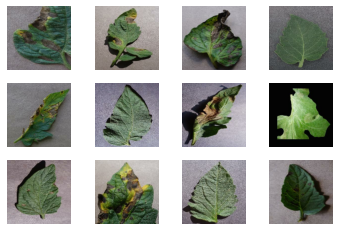

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        

In [ ]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+val_split+test_split==1)
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
    

In [ ]:
train_ds,val_ds,test_ds = get_dataset_partition_tf(dataset)

In [ ]:
len(val_ds)

14

In [ ]:
len(train_ds)

112

In [ ]:
len(test_ds)

15

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
### Building the model  

In [ ]:

# Layer for resizing and normalization 
#     before feeding the image to our model we are resizing the image because even though our input image are 256x256 but we can't
#     be sure if the user enters the image of size 256x256
    
#     we are also normalizing the pixle value between 0 to 1 
#     if we normalize the dataset, we can train the model efficiently with lower computing cost
#     cause each pixle value is between 1 to 255 while traning these value will get multiplied with some weight 
#     and might lead to huge value which lead to huge computation cost 


In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
# Layer for data augmentation 
#     this is needed when we have lesser data this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# applying data augmentation on train ds

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
112/112 [==============================] - 51s 313ms/step - loss: 0.8578 - accuracy: 0.5871 - val_loss: 1.2248 - val_accuracy: 0.5670
Epoch 2/50
112/112 [==============================] - 29s 262ms/step - loss: 0.4930 - accuracy: 0.7956 - val_loss: 0.3706 - val_accuracy: 0.8616
Epoch 3/50
112/112 [==============================] - 29s 261ms/step - loss: 0.3472 - accuracy: 0.8522 - val_loss: 0.4532 - val_accuracy: 0.8393
Epoch 4/50
112/112 [==============================] - 29s 261ms/step - loss: 0.3138 - accuracy: 0.8709 - val_loss: 0.4812 - val_accuracy: 0.8125
Epoch 5/50
112/112 [==============================] - 29s 262ms/step - loss: 0.2684 - accuracy: 0.8905 - val_loss: 0.4245 - val_accuracy: 0.8147
Epoch 6/50
112/112 [==============================] - 30s 265ms/step - loss: 0.3529 - accuracy: 0.8575 - val_loss: 0.4730 - val_accuracy: 0.8058
Epoch 7/50
112/112 [==============================] - 29s 263ms/step - loss: 0.2595 - accuracy: 0.8931 - val_loss: 0.2346 - val_ac

In [ ]:
scores= model.evaluate(test_ds)

15/15 [==============================] - 4s 31ms/step - loss: 0.1450 - accuracy: 0.9479


In [ ]:
scores

[0.14498378336429596, 0.9479166865348816]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

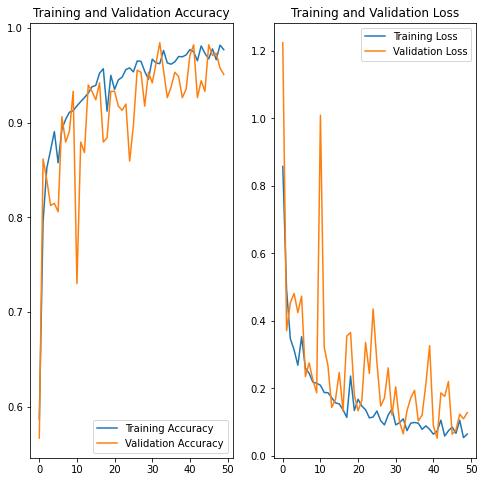

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label: Tomato_Late_blight
Predicted Label: Tomato_Late_blight


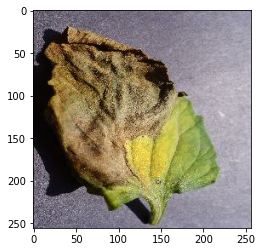

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
model_version = 1
model.save(f"/content/Models/{model_version}")

INFO:tensorflow:Assets written to: /content/Models/1/assets
